# Debugging Machine Learning Models in PyTorch
Welcome to the hands-on session for ML model debugging! In this notebook, you'll learn practical techniques to diagnose and fix issues in neural networks using PyTorch.

**Session Outline (75 min):**
1. Introduction to debugging ML models (5 min)
2. Setup & imports (5 min)
3. Visualizing data and model (5 min)
4. Forward/backward pass debugging (10 min)
5. Model Evaluation (10 min)
5. Common pitfalls and how to fix them (15 min)
6. Practical debugging tools (10 min)
7. Guided exercise: fix a buggy model (10 min)
8. Wrap-up & Q&A (5 min)

## 1. Introduction to Debugging ML Models
Debugging is a critical skill for any machine learning practitioner. Even well-designed models can fail due to subtle bugs, data issues, or training instabilities.

In this session, you will learn:
- How to systematically diagnose problems in neural networks
- Common sources of errors in ML workflows
- Practical tools and techniques for debugging PyTorch models
- How to interpret model outputs and training signals to identify issues

By the end, you'll be able to approach ML model debugging with confidence and efficiency.

## 2. Setup & Imports
In this section, we'll set up the environment and import the necessary libraries for debugging PyTorch models.

In [1]:
# Setup: Import libraries and prepare data/model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time

# Set random seed for reproducibility
torch.manual_seed(42)

The MNIST dataset consists of 28x28 grayscale images of handwritten digits (0-9).
- train_dataset: Contains 60,000 training images and their labels.
- test_dataset: Contains 10,000 test images and their labels.
Each image is transformed to a tensor and normalized for better training stability.
Data loaders (train_loader, test_loader) provide batches of data for model training and evaluation.

In [2]:
# Download and prepare MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

The model defined here is a simple Convolutional Neural Network (CNN) designed for classifying MNIST handwritten digit images. It consists of two convolutional layers followed by two fully connected layers. The convolutional layers extract spatial features from the input images, while the fully connected layers perform classification based on these features. The final output layer produces scores for each of the 10 digit classes (0-9). This architecture is commonly used for image classification tasks and serves as a solid baseline for MNIST.

In [ ]:
NUM_CLASSES = 10

# Define a simple CNN model for MNIST
class ConvNeuralNetwork(nn.Module):
    def __init__(self, num_channels: tuple[int], dropout_prob=0.4):
        assert len(num_channels) == 2, "num_channels should be a tuple of two positive integers."
        super(ConvNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, num_channels[0], kernel_size=3) # -> (ch1, 26, 26)
        self.conv2 = nn.Conv2d(num_channels[0], num_channels[0], stride=2, kernel_size=5) # -> (ch1, 12, 12)
        self.dropout1 = nn.Dropout(dropout_prob)

        self.conv3 = nn.Conv2d(num_channels[0], num_channels[1], kernel_size=5) # -> (ch2, 8, 8)
        self.conv4 = nn.Conv2d(num_channels[1], num_channels[1], stride=2, kernel_size=5) # -> (ch2, 2, 2)
        self.dropout2 = nn.Dropout(dropout_prob)

        self.flat_dim = num_channels[1] * 2 * 2
        self.fc1 = nn.Linear(self.flat_dim, 64)
        self.fc2 = nn.Linear(64, NUM_CLASSES)
        self.dropout3 = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.dropout2(x)
        x = x.view(-1, self.flat_dim)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = F.softmax(self.fc2(x))
        return x

model = ConvNeuralNetwork(num_channels=(32, 64))

## 3. Visualizing Data & Model

Understanding your data and model architecture is a crucial first step in debugging machine learning workflows. In this section, you'll learn how to:

- Visualize sample images and their corresponding labels from the MNIST training set
- Inspect the structure and layers of the convolutional neural network (CNN) model
- Examine model parameters to ensure correct initialization

These visualizations help verify that data is loaded correctly and the model is structured as intended before proceeding to training and debugging.

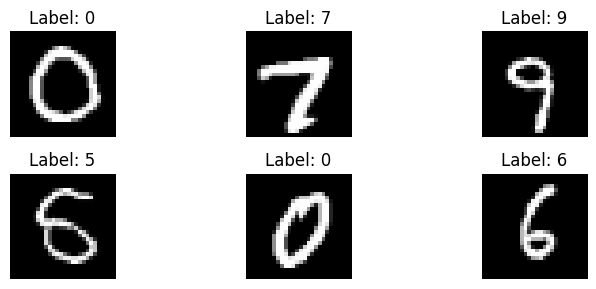

Model architecture:

ConvNeuralNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (dropout1): Dropout(p=0.4, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2))
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (dropout3): Dropout(p=0.4, inplace=False)
)

Model parameters:
conv1.weight: torch.Size([32, 1, 3, 3])
conv1.bias: torch.Size([32])
conv2.weight: torch.Size([32, 32, 5, 5])
conv2.bias: torch.Size([32])
conv3.weight: torch.Size([64, 32, 5, 5])
conv3.bias: torch.Size([64])
conv4.weight: torch.Size([64, 64, 5, 5])
conv4.bias: torch.Size([64])
fc1.weight: torch.Size([64, 256])
fc1.bias: torch.Size([64])
fc2.weight: torch.Size([10, 64])
fc2.bias: torch.Size([10])


In [82]:
# Visualize sample inputs and labels from the training set
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

plt.figure(figsize=(8, 3))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title(f"Label: {example_targets[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Visualize model architecture
print("Model architecture:\n")
print(model)

# Visualize model parameters (layer names and shapes)
print("\nModel parameters:")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

## 4. Forward/Backward Pass Debugging (15 min)
Understanding how data flows through your model and how gradients are computed is essential for effective debugging.

In this section, you'll learn to:
- Inspect activations and outputs at each layer
- Check gradients to ensure proper learning
- Use hooks and manual inspection to debug the forward and backward passes
- Identify issues such as vanishing/exploding gradients or incorrect output shapes

We'll walk through practical examples using PyTorch's autograd and hooks.

In [83]:
# Training loop with loss visualization
def train(model, optimizer, loss, num_epochs: int, train_steps_per_epoch: int = None):
    loss_values = {"train": [], "val": []}
    for epoch in range(1, num_epochs + 1):
        start_time = time.time()

        # Training phase
        model.train()
        running_loss = 0.0
        for i, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            # Convert targets to one-hot encoding for MSE
            target_onehot = F.one_hot(target, num_classes=10).float()
            loss = criterion(output, target_onehot)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if train_steps_per_epoch and i + 1 >= train_steps_per_epoch:
                break

        loss_values["train"].append(running_loss / (i + 1))
    
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                target_onehot = F.one_hot(target, num_classes=10).float()
                loss = criterion(output, target_onehot)
                val_loss += loss.item()
        loss_values["val"].append(val_loss / len(test_loader))
        elapsed_time = time.time() - start_time
    
        print(f"Epoch {epoch}: Average training loss = {loss_values['train'][-1]:.4f}, Validation loss = {loss_values['val'][-1]:.4f}, Elapsed Time = {elapsed_time:.2f} s")
    return loss_values

To train a neural network in PyTorch, you need to define both an optimizer and a loss function. The optimizer updates the model parameters based on the computed gradients, while the loss function measures how well the model's predictions match the true labels.

- **Optimizer:** [torch.optim documentation](https://pytorch.org/docs/stable/optim.html)
- **Loss Function:** [torch.nn documentation](https://pytorch.org/docs/stable/nn.html#loss-functions)

Particularly, the _Adam_ optimizer is a popular choice for training deep learning models. It combines the advantages of two other extensions of stochastic gradient descent: _AdaGrad_ and _RMSProp_. _Adam_ adapts the learning rate for each parameter and uses estimates of first and second moments of the gradients to provide efficient and robust training. Learn more about _Adam_ in the [Adam optimizer documentation](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

In [91]:
# Set up optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

losses = train(model, optimizer, loss=criterion, num_epochs=10, train_steps_per_epoch=None)

/etc/ecmwf/ssd/ssd1/tmpdirs/ecm1924.1529281.20251015_080702.241/ipykernel_2350551/938587307.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


Epoch 1: Average training loss = 2.3497, Validation loss = 2.3477, Elapsed Time = 65.46 s
Epoch 2: Average training loss = 2.3489, Validation loss = 2.3477, Elapsed Time = 62.10 s
Epoch 3: Average training loss = 2.3490, Validation loss = 2.3477, Elapsed Time = 61.47 s
Epoch 4: Average training loss = 2.3490, Validation loss = 2.3477, Elapsed Time = 63.24 s
Epoch 5: Average training loss = 2.3491, Validation loss = 2.3477, Elapsed Time = 61.95 s
Epoch 6: Average training loss = 2.3489, Validation loss = 2.3477, Elapsed Time = 61.44 s
Epoch 7: Average training loss = 2.3489, Validation loss = 2.3477, Elapsed Time = 61.77 s
Epoch 8: Average training loss = 2.3518, Validation loss = 2.3477, Elapsed Time = 61.41 s
Epoch 9: Average training loss = 2.3541, Validation loss = 2.3477, Elapsed Time = 61.21 s
Epoch 10: Average training loss = 2.3522, Validation loss = 2.3477, Elapsed Time = 63.04 s


## 5. Model Validation

Validating your model is crucial to ensure it generalizes well to unseen data and does not simply memorize the training set. In this notebook, we use two main methods for model validation:

1. **Plotting Training and Validation Losses:**  
    By visualizing the loss curves for both the training and validation sets over each epoch, you can monitor the learning process and detect issues such as overfitting (where validation loss increases while training loss decreases) or underfitting (both losses remain high). Consistent and decreasing validation loss indicates good generalization.

2. **Visualizing Predictions on Sample Data:**  
    Examining a few examples from the dataset along with their predicted labels and confidence scores helps you qualitatively assess model performance. This can reveal systematic errors, misclassifications, or areas where the model is uncertain, guiding further debugging and improvement.

3. **Extra Validation Metrics:**  
    Calculating metrics such as accuracy per label, confusion matrices, or heatmaps provides deeper insight into model performance across different classes. These metrics help identify if the model is biased toward certain labels or struggles with specific digits, enabling targeted improvements.

These validation techniques provide both quantitative and qualitative insights into your model's behavior during training.

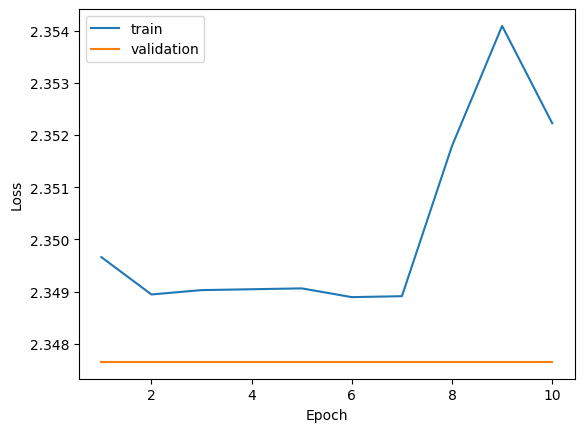

In [92]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(losses["train"]) + 1), losses["train"], label="train")
plt.plot(range(1, len(losses["val"]) + 1), losses["val"], label="validation")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

/etc/ecmwf/ssd/ssd1/tmpdirs/ecm1924.1529281.20251015_080702.241/ipykernel_2350551/938587307.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


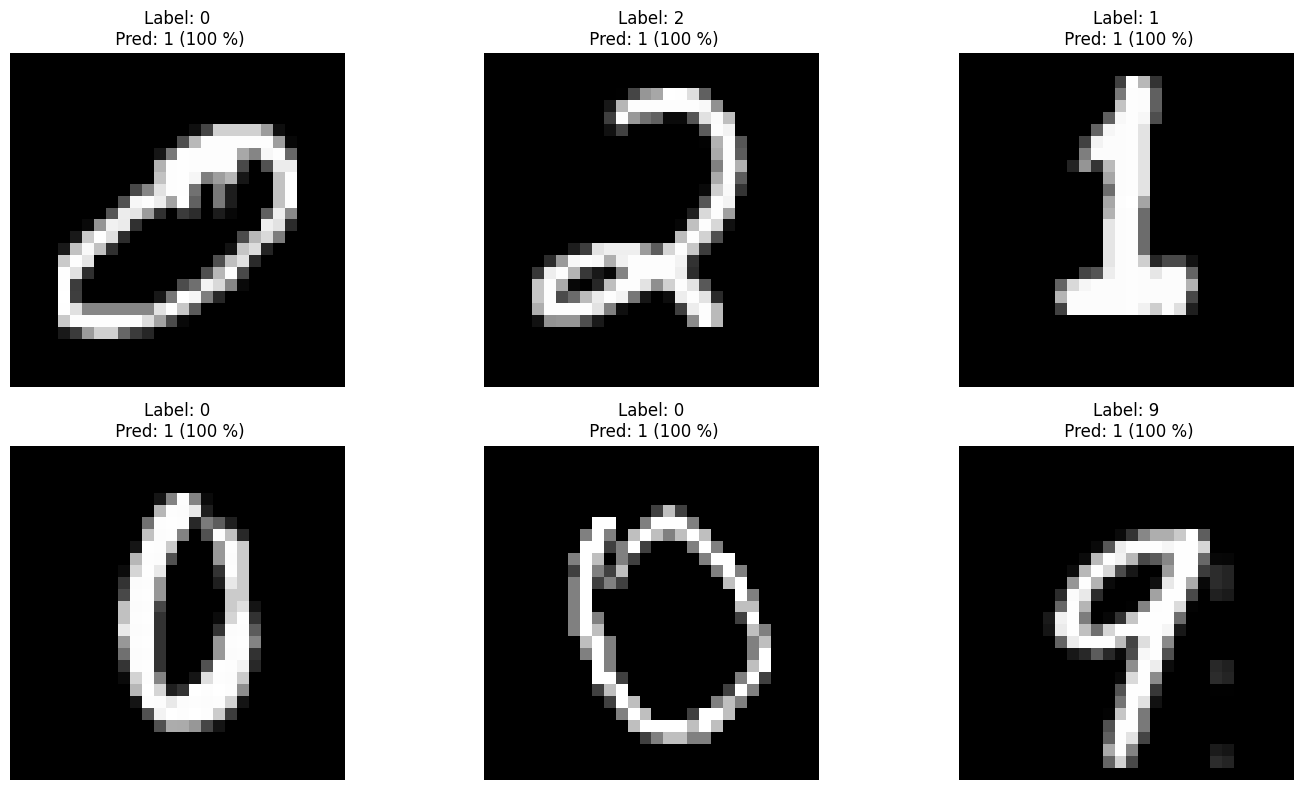

In [93]:
# Visualize sample inputs and labels from the training set
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(example_data[i][0], cmap='gray')
    pred = model(example_data[0]).squeeze()
    label = int(pred.argmax())
    prob = 100 * pred[label]
    plt.title(f"Label: {example_targets[i].item()}\n Pred: {label} ({prob:.0f} %)")
    plt.axis('off')
plt.tight_layout()
plt.show()

/etc/ecmwf/ssd/ssd1/tmpdirs/ecm1924.1529281.20251015_080702.241/ipykernel_2350551/2567974273.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


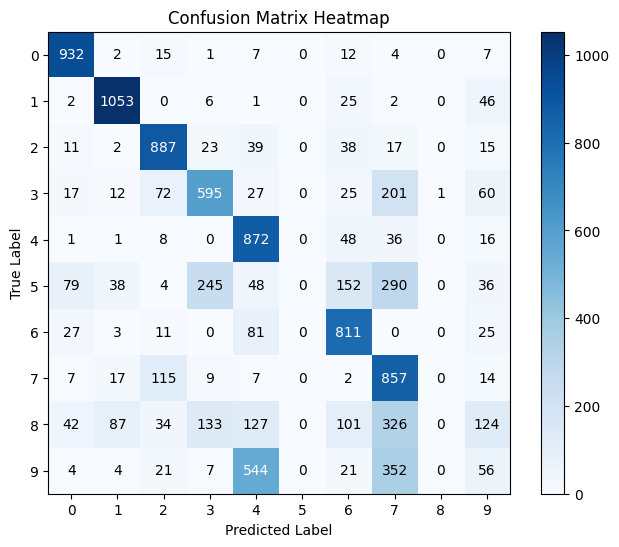

In [ ]:
from sklearn.metrics import confusion_matrix

# Get all predictions and true labels from the test set
all_preds = []
all_targets = []
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Heatmap")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel("Predicted Label")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

## 6. Common Pitfalls and How to Fix Them
Machine learning models often fail due to subtle bugs or data issues. Recognizing common pitfalls can save significant debugging time.

Key issues to watch for:
- Data leakage between train/test sets
- Incorrect loss function or output activation
- Poor data normalization or preprocessing
- Overfitting or underfitting
- Vanishing/exploding gradients
- Misaligned labels or targets

We'll demonstrate how to detect and address these problems in practice.

## 7. Practical Debugging Tools
PyTorch and the Python ecosystem offer powerful tools for debugging ML models.

Recommended tools and techniques:
- `torch.autograd` for inspecting gradients and computation graphs
- Forward/backward hooks for monitoring activations and gradients
- TensorBoard for visualizing metrics and model graphs
- Matplotlib for plotting loss, accuracy, and predictions (See section 5)
- Printing shapes and values at key points in the model

We'll show how to use these tools to quickly identify and resolve issues.

## 8. Guided Exercise: Fix a Buggy Model
Now it's your turn! Below is a model with intentional bugs. Try to identify and fix the issues using the debugging techniques we've covered.

Steps:
1. Run the code and observe any errors or unexpected outputs.
2. Use visualization, hooks, and print statements to diagnose the problem.
3. Fix the bugs and verify the model trains correctly.

Discuss your findings and solutions with your peers.

## 9. Wrap-up & Q&A
Congratulations on completing the debugging session!
- Review the key techniques and tools for debugging ML models
- Share your experiences and ask questions
- Explore further resources for advanced debugging and model analysis

Thank you for participating!